In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import PIL.Image
from datetime import datetime
import PIL.ExifTags

import dateutil.parser
import os
import re

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, MaxNLocator)

from pyphasechip import pyphasechip_logic as pypc
from typing import Tuple

## Variables

In [2]:
# reagent 1 name
name_sol1 = "BSA"
# reagent 1 starting contentration
initial_conc_sol1 = 266
# unit
unit_sol1 = "µM"


# reagent 2 name
name_sol2 = "PEG"
# reagent 2 starting concentration
initial_conc_sol2 = 10
# unit
unit_sol2 = "%"


# mixing ratio of the concentrations 0
# [1:X]
initial_ratio = 7


# Number of different concentrations used
number_of_diff_conc = 3

# Number of wells per horizontal(!) line per concentrations
# full chip equals 10
n_wells = 1

# How many hours did the experiment last?
hours_of_experiment = 17


# How many pictures where taken per hour per well?
images_per_hour = 1

###### delete hoe and iph, use this instead
# total amount of images
total_n_images = 102
n_timepoints = int(total_n_images / (number_of_diff_conc * n_wells * 2)) 

# percental difference of img mean to all previous imgages. 
# value is similar to a sensivity-value
percental_threshold = 32


# measured diameter of chamber to calculate radii for circle detection -> min and max [px]
# around +-30 of the real value, best measured with something like imageJ/Fiji
diameter = 238 
minRadiusChamber = int((diameter/2)*0.7)
maxRadiusChamber = int((diameter/2)*1.3)


# height of chamber [µm]
chamber_height = 60

# folder where images are stored
# best is to use only paths without any whitespace
#image_folder = "C:Users/DigitalStation/Documents/Universität Stuttgart/Institut für industrielle Bioverfahrenstechnik/1_Masterthesis/Experiments/20210804 First OFM Exp/Images"
#image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\TestImages"

image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\testimages2+"
#image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\TestImages3"

# datatype of the images
extension = ".jpg"

# TODO: use a .yml file for storing these variables

In [ ]:
#THIS IS FOR CELLOBSERVER/ZEISS IMAGES ONLY

def get_sorted_file_list(image_folder: str) -> list:
    files, times, concs, wells = [], [], [], []
    
    for file in os.listdir(image_folder):
        # 1. More robust, faster, but more specific
        c, w, _, t = re.search("c(\d+)_w(\d+)_s(\d+)t(\d+)", file).groups()

        # 2. Other way
        #c, w, _, t, *params = re.findall('[0-9]+', file)
        
        # Generate lists
        times.append(int(t))
        concs.append(int(c))
        wells.append(int(w))
        files.append(file)
        
    return [x for _, _, _, x in sorted(zip(concs, times, wells, files))]
    
get_sorted_file_list(image_folder)

## Programm

In [3]:
# Create all the necessary dicts and lists
image_list, image_names, data_well, well, concentration, time_resolution = pypc.create()

# Load images & convert to grayscale
pypc.images_to_list(image_list, image_names, image_folder, extension)
pypc.images_to_dict(hours_of_experiment, images_per_hour, number_of_diff_conc, n_wells, image_list, image_names,
                    time_resolution, concentration, well, data_well)
starting_conc = pypc.starting_concentration(initial_conc_sol1, initial_conc_sol2, initial_ratio)

well_nr = 0
for conc_nr in range(number_of_diff_conc):
    for n_rows_per_conc in range(2):
        for n_wells_per_row in range(n_wells):
            
            # Initialise variables, arrays and lists
            well_data = np.zeros(shape=(2, 3))
            centerpoints = np.zeros(shape=(2, 2))
            elon_mask = np.zeros(shape=time_resolution[0][0][0]['gray'].shape, dtype="uint8")
            threshed_img = np.zeros(shape=time_resolution[0][0][0]['gray'].shape, dtype="uint8")
            areas = np.zeros(shape=(1, 2))
            droplet_arr = np.zeros(shape=(2,4))
            r_old_hv = np.zeros(2)
            mean_list = []
            llps_status = False
            r_0 = 0
            n_0 = 0
            
            for time_idx in range(n_timepoints): #n_timepoints
                if llps_status is False:
                    print("---", "C:", conc_nr, "W:", well_nr, " T:", time_idx, "---")

                    image = time_resolution[time_idx][conc_nr][well_nr]['gray'].copy()

                    x_abs, y_abs, centerpoints, well_data, elon_mask, masked_img, droplet_found, l, l_vert, norm_pp_len_h,norm_pp_len_v, img, f, N, E, S, W, x, y, droplet_arr, areas, radius_old_hv, hor, vert, r_0 = pypc.droplet_detection(diameter, image, well_data, elon_mask, centerpoints, llps_status, droplet_arr, r_0, time_idx, areas, r_old_hv)
                    time_resolution[time_idx][conc_nr][well_nr]['img'] = img
                    time_resolution[time_idx][conc_nr][well_nr]['normg_pp_len_h'] = norm_pp_len_h # needed for display
                    time_resolution[time_idx][conc_nr][well_nr]['normg_pp_len_v'] = norm_pp_len_v # needed for display
                    time_resolution[time_idx][conc_nr][well_nr]['l'] = l # needed for display
                    time_resolution[time_idx][conc_nr][well_nr]['l_vert'] = l_vert # needed for display
                    time_resolution[time_idx][conc_nr][well_nr]['masked img'] = masked_img 
                    time_resolution[time_idx][conc_nr][well_nr]['manipulated img'] = img # needed for display
                    time_resolution[time_idx][conc_nr][well_nr]['x abs'] = x_abs # needed for display
                    time_resolution[time_idx][conc_nr][well_nr]['y abs'] = y_abs # needed for display
                    time_resolution[time_idx][conc_nr][well_nr]['radius'] = droplet_arr[0, 0] # needed for display
                    time_resolution[time_idx][conc_nr][well_nr]['x'] = x # needed for display
                    time_resolution[time_idx][conc_nr][well_nr]['y'] = y # needed for display
                    time_resolution[time_idx][conc_nr][well_nr]['r'] = well_data[0, 2] # needed for display
                    time_resolution[time_idx][conc_nr][well_nr]['N'] = N
                    time_resolution[time_idx][conc_nr][well_nr]['E'] = E
                    time_resolution[time_idx][conc_nr][well_nr]['S'] = S
                    time_resolution[time_idx][conc_nr][well_nr]['W'] = W
                    
                    time_resolution[time_idx][conc_nr][well_nr]['well data'] = well_data
                    time_resolution[time_idx][conc_nr][well_nr]['mask'] = elon_mask
                    time_resolution[time_idx][conc_nr][well_nr]['hor'] = hor
                    time_resolution[time_idx][conc_nr][well_nr]['vert'] = vert
                    

                    llps_status, areas, mean_list, droplet_arr, squi, cro_squi, n_0 = pypc.detect_LLPS(percental_threshold, droplet_arr, llps_status, img, time_idx, areas, mean_list, droplet_found, n_0)
                    time_resolution[0][conc_nr][well_nr]['areas'] = areas
                    time_resolution[0][conc_nr][well_nr]['mean list'] = mean_list
                    time_resolution[time_idx][conc_nr][well_nr]['squ'] = squi
                    time_resolution[time_idx][conc_nr][well_nr]['cro squ'] = cro_squi
                    
                    time_resolution[time_idx][conc_nr][well_nr]['droplet array'] = droplet_arr


                    if llps_status is True:
                        # save img time where llps was found
                        print(conc_nr, well_nr, time_idx)
                        time_resolution[0][conc_nr][well_nr]['time idx'] = time_idx
                        # save name of image where LLPS was detected
                        time_resolution[0][conc_nr][well_nr]['LLPS name'] = time_resolution[time_idx][conc_nr][well_nr]['name']
                        # calculate the critical concentration
                        llps_conc = pypc.ccrit_calculation(starting_conc, areas, conc_nr)
                        time_resolution[0][conc_nr][well_nr]['LLPS conc'] = llps_conc
                    
            well_nr += 1
    well_nr = 0


# saves the image names where LLPS was detected and the calculated concentrations to a csv file
# .csv gets safed in the image folder
#pypc.save_results_to_csv(time_resolution, image_folder, number_of_diff_conc, n_wells, hours_of_experiment,
#                       images_per_hour, name_sol1, name_sol2, unit_sol1, unit_sol2)

Creating and sorting image list


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:02<00:00, 40.37it/s]


writing images into big dictionary


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 60.26it/s]


--- C: 0 W: 0  T: 0 ---
detect wells & droplets and create masks
- well found: True
mid_start: 132
0 0 L: 58.0 R: 207.0 m: 132.0
0 1 L: 31.0 R: 231.0 m: 131.0
0 2 L: 18.0 R: 244.0 m: 131.0
0 3 L: 14.0 R: 240.0 m: 127.0
0 4 L: 17.0 R: 247.0 m: 132.0
0 5 L: 30.0 R: 170.0 m: 100.0
0 6 L: 54.0 R: 210.0 m: 132.0
r_old: [0. 0.]
result after first filters
[132. 131. 131. 127. 132. 100. 132.]
average in while loop: 126.42857142857143  - np.max: 20.90395480225989
delets idx: 5
result after both filters:
midpoints [132. 131. 131. 127. 132.   0. 132.]
diameters [149. 200. 226. 226. 230.   0. 156.]
result: mid_rel calc:  130
mid_start: 132
1 0 L: 79.0 R: 209.0 m: 144.0
1 1 L: 31.0 R: 235.0 m: 133.0
1 2 L: 19.0 R: 248.0 m: 133.0
1 3 L: 14.0 R: 252.0 m: 133.0
1 4 L: 15.0 R: 249.0 m: 132.0
1 5 L: 32.0 R: 235.0 m: 133.0
1 6 L: 58.0 R: 209.0 m: 133.0
r_old: [0. 0.]
result after first filters
[144. 133. 133. 133. 132. 133. 133.]
result after both filters:
midpoints [144. 133. 133. 133. 132. 133. 133.]
d

C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\pythonProject\PyPhaseChip\pyphasechip\pyphasechip_fun.py:348: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.sum(mid_rel_pp_plots[n, :]) / np.count_nonzero(mid_rel_pp_plots[n, :])


Fallback: 430 287
perc. diff.:  0.0
[[   71.     427.     280.   15828.74]
 [   71.     427.     280.   15828.74]]
--- C: 1 W: 1  T: 2 ---
detect wells & droplets and create masks
- well found: True
mid_start: 129
0 0 L: 82.0 R: 165.0 m: 123.0
0 1 L: 43.0 R: 204.0 m: 123.0
0 2 L: 68.0 R: 221.0 m: 144.0
0 3 L: 15.0 R: 140.0 m: 77.0
0 4 L: 33.0 R: 227.0 m: 130.0
0 5 L: 29.0 R: 215.0 m: 122.0
0 6 L: 52.0 R: 178.0 m: 115.0
r_old: [82. 72.]
diameter temp 83.0 < diameter old (small) 139.4
r_deleted: 0 83.0
diameter temp 125.0 < diameter old (small) 139.4
r_deleted: 3 125.0
diameter temp 194.0 > diameter old (big) 180.4
r_deleted: 4 194.0
diameter temp 186.0 > diameter old (big) 180.4
r_deleted: 5 186.0
diameter temp 126.0 < diameter old (small) 139.4
r_deleted: 6 126.0
result after first filters
[  0. 123. 144.   0.   0.   0.   0.]
result after both filters:
midpoints [  0. 123. 144.   0.   0.   0.   0.]
diameters [  0. 161. 153.   0.   0.   0.   0.]
result: mid_rel calc:  133
mid_start: 129

In [4]:
for c in range(3):
    for w in range(2):
        print(time_resolution[0][c][w]['time idx'])

6
6
3
3
7
3


In [15]:
# Python3 implementation of the approach
from math import sqrt


x1 = 473
y1 = 188
x2 =503 
y2 = 141
x3 = 502
y3 = 354
            
# Function to find the circle on
# which the given three points lie
def findCircle(x1, y1, x2, y2, x3, y3) :
	x12 = x1 - x2;
	x13 = x1 - x3;

	y12 = y1 - y2;
	y13 = y1 - y3;

	y31 = y3 - y1;
	y21 = y2 - y1;

	x31 = x3 - x1;
	x21 = x2 - x1;

	# x1^2 - x3^2
	sx13 = pow(x1, 2) - pow(x3, 2);

	# y1^2 - y3^2
	sy13 = pow(y1, 2) - pow(y3, 2);

	sx21 = pow(x2, 2) - pow(x1, 2);
	sy21 = pow(y2, 2) - pow(y1, 2);

	f = (((sx13) * (x12) + (sy13) *
		(x12) + (sx21) * (x13) +
		(sy21) * (x13)) // (2 *
		((y31) * (x12) - (y21) * (x13))));
			
	g = (((sx13) * (y12) + (sy13) * (y12) +
		(sx21) * (y13) + (sy21) * (y13)) //
		(2 * ((x31) * (y12) - (x21) * (y13))));

	c = (-pow(x1, 2) - pow(y1, 2) -
		2 * g * x1 - 2 * f * y1);

	# eqn of circle be x^2 + y^2 + 2*g*x + 2*f*y + c = 0
	# where centre is (h = -g, k = -f) and
	# radius r as r^2 = h^2 + k^2 - c
	h = -g;
	k = -f;
	sqr_of_r = h * h + k * k - c;

	# r is the radius
	r = round(sqrt(sqr_of_r), 5);

	print("Centre = (", h, ", ", k, ")");
	print("Radius = ", r);

# Driver code
if __name__ == "__main__" :
	

	findCircle(x1, y1, x2, y2, x3, y3);

# This code is contributed by Ryuga


Centre = ( 619 ,  249 )
Radius =  158.23084


In [ ]:
t = 4
c = 2
w = 0

fig, axs = plt.subplots(3,1, figsize=(15, 9), facecolor='w', edgecolor='k')
axs[0].imshow(time_resolution[t][c][w]['squ'], cmap="gray")
axs[1].imshow(time_resolution[t][c][w]['cro squ'], cmap="gray")

print(np.count_nonzero(time_resolution[t][c][w]['squ']))
print(time_resolution[t][c][w]['radius'])
print("meanlist", time_resolution[0][c][w]['mean list'])

r = int(np.sqrt(40801/3.14))
d = int((0.61 * r))
#x = time_resolution[time_idx][conc_nr][well_nr]['x abs']
#y = time_resolution[time_idx][conc_nr][well_nr]['y abs']
cropped_squircled_pixels = time_resolution[t][c][w]['squ'][y - d:y + d, x - d:x + d]
axs[2].imshow(cropped_squircled_pixels, cmap="gray")

In [ ]:
conc_nr = 2
well_nr = 0
time_idx = 4
print(time_resolution[time_idx][conc_nr][well_nr]['well data'])
time_resolution[time_idx][conc_nr][well_nr]['mask']

In [ ]:
m = 1.2
n = 1.1
imgage = time_resolution[2][conc_nr][well_nr]['gray'].copy()

x, y, r = find_well(imgage, diameter, m, n, param1=200, param2=0.9)
print(x, y, r)
cimage = cv2.circle(imgage, (x, y), r, (255, 0, 0), 3)
plt.imshow(cimage)


434 286 74.0
count zeros 250
0.07661290322580645


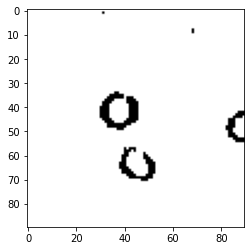

In [5]:
#time_resolution[5][0][1]['radius']

conc_nr = 1
well_nr = 0
time_idx = 3


x_abs = time_resolution[time_idx][conc_nr][well_nr]['x abs']
y_abs = time_resolution[time_idx][conc_nr][well_nr]['y abs']
r = time_resolution[time_idx][conc_nr][well_nr]['radius']
a = time_resolution[time_idx][conc_nr][well_nr]['squ'].copy()
a.shape
#plt.imshow(a, cmap='gray')
print(x_abs, y_abs, r)
d = int(0.61*r)
crop = a[y_abs-d:y_abs+d,x_abs-d:x_abs+d]
plt.imshow(crop, cmap='gray')

liste =[]
n = 0
for idx, value in enumerate(crop):
    for i, val in enumerate(crop[idx]):
        if val == 0:
            n += 1
            liste.append(i)
print("count zeros", n)
s = []
for idx, val in enumerate(liste):
    if idx > 1:
        s.append(liste[idx-1]-liste[idx])
avg_distance = sum(s)/len(s)
print(avg_distance)



radius 66.0
121.0 66.0


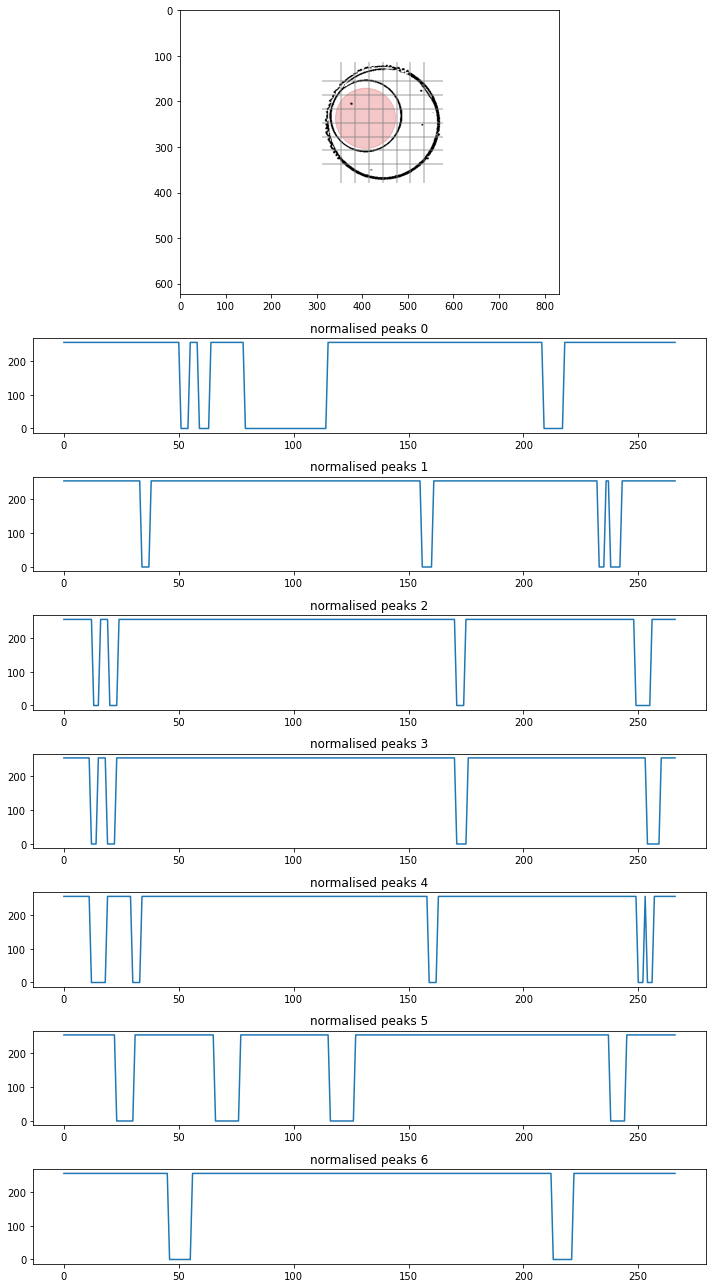

In [10]:
### Plot


conc_nr = 2
well_nr = 0
time_idx = 0

img = time_resolution[time_idx][conc_nr][well_nr]['img'] 
norm_pp_len_h = time_resolution[time_idx][conc_nr][well_nr]['normg_pp_len_h']
l = time_resolution[time_idx][conc_nr][well_nr]['l'] 
x_abs = time_resolution[time_idx][conc_nr][well_nr]['x abs']
y_abs = time_resolution[time_idx][conc_nr][well_nr]['y abs']
radius_est = time_resolution[time_idx][conc_nr][well_nr]['radius']
x = time_resolution[time_idx][conc_nr][well_nr]['x'] 
y = time_resolution[time_idx][conc_nr][well_nr]['y']
r = time_resolution[time_idx][conc_nr][well_nr]['r'] 
N = time_resolution[time_idx][conc_nr][well_nr]['N'] 
E = time_resolution[time_idx][conc_nr][well_nr]['E'] 
S = time_resolution[time_idx][conc_nr][well_nr]['S'] 
W = time_resolution[time_idx][conc_nr][well_nr]['W'] 

print("radius", radius_est)
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(nrows=8, figsize=(10, 18), gridspec_kw={"height_ratios": [0.3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]})
ax1.imshow(img, cmap="gray")
print(r, radius_est)

#img_hL = cv2.line(img.copy(), (W,y), (E,y), (255,0,0), 2)
ax1.hlines(y, W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y + r / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y + (0.5 * r) / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y - 0.5 * r / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y - r / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y + 1.5 * r/2), W,E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y - 1.5 * r/2), W,E, color="tab:gray", alpha=0.5)

ax1.vlines(x, N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x + r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x + 0.5 * r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x - 0.5 * r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x - r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x + 1.5 * r/2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x - 1.5 * r/2), N, S, color="tab:gray", alpha=0.5)



#circle = plt.Circle((x_ass, y_ass), radius, color='tab:red', alpha=0.25)
circle = plt.Circle((x_abs, y_abs), radius_est, color='tab:red', alpha=0.25)

ax1.add_patch(circle)
#ax1.hlines(y_ass, x_ass-10, x_ass+10, color='tab:blue', linewidth=5)

ax2.plot(l, norm_pp_len_h[0])
ax2.set_title("normalised peaks 0")

ax3.plot(l, norm_pp_len_h[1])
ax3.set_title("normalised peaks 1")

ax4.plot(l, norm_pp_len_h[2])
ax4.set_title("normalised peaks 2")

ax5.plot(l, norm_pp_len_h[3])
ax5.set_title("normalised peaks 3")

ax6.plot(l, norm_pp_len_h[4])
ax6.set_title("normalised peaks 4")

ax7.plot(l, norm_pp_len_h[5])
ax7.set_title("normalised peaks 5")

ax8.plot(l, norm_pp_len_h[6])
ax8.set_title("normalised peaks 6")

#ax9.plot(l, np.sum(norm_pp_len_h, axis=0))
#ax9.set_title("summed peaks")
#ax9.hlines(5, np.min(l),np.max(l), color="tab:orange")
fig.tight_layout()
#fig.savefig(f"t{time_idx}_c{conc_nr}_w{well_nr}_self-dev-Algo.png")

In [ ]:
### Plot
img = time_resolution[time_idx][conc_nr][well_nr]['img'] 
norm_pp_len_v = time_resolution[time_idx][conc_nr][well_nr]['normg_pp_len_v']
l_vert = time_resolution[time_idx][conc_nr][well_nr]['l_vert'] 




fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(nrows=8, figsize=(10, 18), gridspec_kw={"height_ratios": [0.3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]})
ax1.imshow(img, cmap="gray")


#img_hL = cv2.line(img.copy(), (W,y), (E,y), (255,0,0), 2)
ax1.hlines(y, W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y + r / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y + (0.5 * r) / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y - 0.5 * r / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y - r / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y + 1.5 * r/2), W,E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y - 1.5 * r/2), W,E, color="tab:gray", alpha=0.5)

ax1.vlines(x, N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x + r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x + 0.5 * r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x - 0.5 * r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x - r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x + 1.5 * r/2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x - 1.5 * r/2), N, S, color="tab:gray", alpha=0.5)


#circle = plt.Circle((x_ass, y_ass), radius, color='tab:red', alpha=0.25)
circle = plt.Circle((x_abs, y_abs), radius_est, color='tab:red', alpha=0.25)
#circle = plt.Circle((x_abs, 110+y-2*radius_est), radius_est, color='tab:green', alpha=0.25)


ax1.add_patch(circle)
#ax1.hlines(y_ass, x_ass-10, x_ass+10, color='tab:blue', linewidth=5)

ax2.plot(norm_pp_len_v[0])
ax2.set_title("normalised peaks 0")

ax3.plot(l_vert, norm_pp_len_v[1])
ax3.set_title("normalised peaks 1")

ax4.plot(l_vert, norm_pp_len_v[2])
ax4.set_title("normalised peaks 2")

ax5.plot(l_vert, norm_pp_len_v[3])
ax5.set_title("normalised peaks 3")

ax6.plot(l_vert, norm_pp_len_v[4])
ax6.set_title("normalised peaks 4")

ax7.plot(l_vert, norm_pp_len_v[5])
ax7.set_title("normalised peaks 5")

ax8.plot(l_vert, norm_pp_len_v[6])
ax8.set_title("normalised peaks 6")
fig.tight_layout()
#fig.savefig("t2_c0_w1_nuMethod.png")

In [ ]:
conc_nr = 2
well_nr = 0
time_idx = 3

c = 5
fig, axs = plt.subplots(c,1, figsize=(15, 6), facecolor='w', edgecolor='k')


axs = axs.ravel()

for t in range(c):
    print(t)
    axs[t].plot(time_resolution[t][conc_nr][well_nr]['normg_pp_len_v'][0])

for t in range(c):
    axs[t].plot(time_resolution[t][conc_nr][well_nr]['vert'][0])


In [ ]:
time_resolution[0][0][0]['normg_pp_len_h']

## quality control

In [ ]:
#5,0,0

# time to check
time_idx = 5

# concentration to check
conc_nr = 0

# well to check
well_nr = 0


# uncomment this to get some insight into image processing
pypc.quality_control(time_resolution, time_idx, conc_nr, well_nr, name_sol1, name_sol2,
                     unit_sol1, unit_sol2, starting_concentrations, time_resolution[0][conc_nr][well_nr]['well geometry'])

In [ ]:
from csaps import csaps

def outside_std_dev(derv: np.ndarray) -> np.ndarray:
    # Checks if value is outside the 1st std
    # if so, it sets the value to 1, all other values are zeros
    outside_std = np.zeros(len(derv))
   
    for idx, y in enumerate(derv):
        if (y > np.median(derv) + 2 * np.std(derv)): #or (y < np.median(derv) - 2 * np.std(derv)):
            outside_std[idx] = 1
    
    return outside_std
            
    
def average_peaks(array, averaging_length):
    change = True

    while change == True:
        change = False
        for index, val in enumerate(array):
            if val == 1:
                for i in range(averaging_length):
                    index2 = index + i + 1
                    if index2 < len(array):
                        arr_value = array[index2]
                        if arr_value == 1:
                            mean_idx = int((index + index2)/2)
                            array[index] = 0
                            array[index2] = 0
                            array[mean_idx] = 1 
                            change = True
    
    return array


def find_edges(temp: np.ndarray, n: int):
    solns = []
    solns_temp = []
    check = []
    
    for array_idx, val in enumerate(temp):
        if np.count_nonzero(val) == 4:
            check.append(array_idx)
    
    if check:
        print("There are 4 peaks!")
        print(check)
        for i in range(len(check)):
            solns_temp = []
            for peak_index, peak_val in enumerate(temp[check[i]]):
                if peak_val == 1:
                    solns_temp.append(peak_index)
                solns_temp.sort()

            print("solns temp", solns_temp)
           
            solns.append(solns_temp[int(len(solns_temp)/2 - 1 - n)])
            solns.append(solns_temp[int(len(solns_temp)/2 + n)])
                        
    else:
        print("only 2 peaks")
        for array_index, whole_array in enumerate(temp):
            if np.count_nonzero(temp[array_index]) % 2:
                pass
            else:
                for peak_index, peak_value in enumerate(temp[array_index]):
                    if peak_value == 1:
                        solns.append(peak_index)
                       
    print("solns", solns)

    return solns


def compute_droplet_list(x, y, r, f, edges_h, edges_v):
    # calculate absolute coordinates for the droplet edges
    means = np.zeros(shape=(2,1))
    upperleftX = []
    upperleftY = []
    lowerrightX = []
    lowerrightY = []
    start_x = int(x - r * f)  # x-values where the horizontal lines start
    start_y = int(y - r * f)  # y-values where the horizontal lines start

    print("inc. array h", edges_h)
    x_mean = int(sum(edges_h) / len(edges_h))
    x_assumed = x_mean + start_x
      
    print("inc. array v", edges_v)
    y_mean = int(sum(edges_v) / len(edges_v))
    y_assumed = y_mean + start_y
    
    means[0] = x_mean
    means[1] = y_mean
    
    for n, X in enumerate(edges_h):
        if n%2:
            lowerrightX.append(X)
        else:
            upperleftX.append(X)
            
    for n, Y in enumerate(edges_v):
        if n%2:
            lowerrightY.append(Y)
        else:
            upperleftY.append(Y)

    uL = (int(sum(upperleftX)/len(upperleftX)), int(sum(upperleftY)/len(upperleftY)))
    lR = (int(sum(lowerrightX)/len(lowerrightX)), int(sum(lowerrightY)/len(lowerrightY)))
    print("ul",uL)
    print("lR", lR)
    
    vector = np.subtract(lR, uL)
    print("vector", vector)
    
    # make shure the values do not differ more than 10%, otherwise choose bigger vector
    if np.max(vector) > np.min(vector) * 1.1:
        diameter = np.max(vector)
    else:
        diameter = np.min(vector)

    radius = int(diameter * 0.5)
        
    print("x ass", x_assumed)
    print("y ass", y_assumed)
    print("r", radius)
    
    #just for fixing, delete later
    uL = (uL[0]+start_x, uL[1]+start_y)
    lR = (lR[0]+start_x, lR[1]+start_y)

    return x_assumed, y_assumed, radius, means, uL, lR, vector


def smooth_data(x, y):
    xi = np.linspace(x[0], x[-1], len(x))
    smoothed_data = csaps(x, y, xi, smooth=0.5)
    
    return smoothed_data


# create mask
def create_mask(img, mask, well_data, x, y, r):
    # read information from circle detection
    x0 = x
    y0 = y
    radius = r * 1.05
       
    # checks if well position in current img differs too much from
    # well position in previous img
    if well_data[1,0] != 0:
        x_dif = abs(100 - x / well_data[1,0] * 100)
        y_dif = abs(100 - y / well_data[1,1] * 100)
        r_dif = abs(100 - r / well_data[1,2] * 100)

        if x_dif > dev or y_dif > dev or r_dif > dev:
            elon_mask = np.zeros(shape=img.shape, dtype="uint8")
            # iterate over image, equ. checks if pixel is part of the circle
            for idx1 in range(img.shape[0]):
                for idx2 in range(img.shape[1]):
                    if (idx2 - x0) ** 2 + (idx1 - y0) ** 2 < radius ** 2:
                        elon_mask[idx1][idx2] = 255  
        else:
            elon_mask = mask
    else:
        elon_mask = np.zeros(shape=img.shape, dtype="uint8")
        # iterate over image, equ. checks if pixel is part of the circle
        for idx1 in range(img.shape[0]):
            for idx2 in range(img.shape[1]):
                if (idx2 - x0) ** 2 + (idx1 - y0) ** 2 < radius ** 2:
                    elon_mask[idx1][idx2] = 255  
    
    well_data[1,0] = x
    well_data[1,1] = y
    well_data[1,2] = r 

    return elon_mask, well_data


# masking image
def mask_image(img, elon_mask):
    img[elon_mask == 0] = 255
    img[elon_mask != 0] = img[elon_mask != 0]

    return img


def normalise_peaks(norm_peaks_h: np.ndarray, avg_peaks_v: np.ndarray):
    delta = []
    delta_minus = []
    
    for idx, val in enumerate(norm_peaks_h[2]):
        if val == 1:
            outer_edge_well = idx
            break
    
    for n in (0, 1, 3, 4):
        for idx, val in enumerate(norm_peaks_h[n]):
            if val == 1:
                edge_well = idx
                delta_length = edge_well - outer_edge_well
                break
            for l in range(delta_length):
                delta.append(l)
                print("delta", delta)
            
            for i in range(len(delta)):
                calc = (len(norm_peaks_h)-1) - i
                delta_minus.append(calc)
            
            avg_norm_peaks_h = np.delete(norm_peaks_h, delta_minus)
            avg_norm_peaks_h = np.delete(avg_norm_peaks_h, delta)
         
        
    return


def droplet_detection_algorithm(x: int, y: int, r: int, f: float, outside_std_dev_h: np.ndarray, outside_std_dev_v: np.ndarray, length:int):
    means = np.zeros(shape=(2,1))
    means[0] = 6
    means[1] = 10
    averaged_peaks_h = np.zeros(shape=(5, length))
    averaged_peaks_v = np.zeros(shape=(5, length))
    n = 0
    
    for i in outside_std_dev_h:
        averaged_peaks_h[i] = average_peaks(outside_std_dev_h[i].copy(), 5)
        averaged_peaks_v[i] = average_peaks(outside_std_dev_v[i].copy(), 5)
    
    while np.min(means) < np.max(means) * 0.8: #n < np.min((len(averaged_peaks_h),len(averaged_peaks_v)))
        print(n)
        print("find edges h")
        solns_h = find_edges(averaged_peaks_h, n)
        print("find edges v")
        solns_v = find_edges(averaged_peaks_v, n)
        print("compute droplet")
        x_ass, y_ass, radius, means, uL, lR, vector = compute_droplet_list(x, y, r, f, solns_h, solns_v)
        n += 1
        
    return x_ass, y_ass, radius, averaged_peaks_h, averaged_peaks_v, uL, lR, vector
    
    # include averaged peaks, also good option to adjust stuff
    #options:
    #compare means of solns
    #compare distance between points

In [ ]:
def normalise_profile_plot_length(norm_peaks: np.ndarray):
    delta = np.zeros(5)
    delta_minus = np.zeros(5)
    delta_length = 0
    avg_norm_peaks = np.zeros(shape=(5, len(norm_peaks[2])))
    temp = np.zeros(len(norm_peaks[2]))
    
    for idx, val in enumerate(norm_peaks[2]):
        if val == 0:
            outer_edge_well = idx
            break
    
    for n in (0, 1, 3, 4):
        add = []
        temp = norm_peaks[n].copy()

        for idx, val in enumerate(norm_peaks[n]):
            if val == 0:
                edge_well = idx
                delta_length = edge_well - outer_edge_well
                break
                
        delta[n] = delta_length
                
        for i in range(int(delta[n])):
            i_minus = (len(norm_peaks[2]) - 1) - i
            temp = np.delete(temp, i_minus)
            
        for i in range(int(delta[n])):
            temp = np.delete(temp, i)
            for a in range(2):
                add.append(np.max(temp))
                
        mid = int(len(norm_peaks[2])/2)
        avg_norm_peaks[n] = np.insert(temp, mid, add)
        avg_norm_peaks[2] = norm_peaks[2]
        
    return avg_norm_peaks


def compute_droplet_from_peaks(x: int, y: int, r: int, f: float, norm_edges: np.ndarray, centerpoints: np.ndarray, n:int):
    # n can be 0 for horizontal or 1 for vertical
    edges_idx = np.zeros(shape=(2,2))
    start_x = int(x - r * f)  # x-values where the horizontal lines start
    start_y = int(y - r * f)  # y-values where the horizontal lines start

    summed_edges = np.sum(norm_edges, axis=0)
    
    # accounts for a moving droplet center
    if centerpoints[0,n] == 0:
           mid = int(len(summed_edges)/2)
    else:
        centerpoint[1,n] = centerpoint[0,n]
        mid = centerpoint[1,n]
    
    # Dinesh: is there a better way to code this?
    # "walk" right/left from center until value is below 3, save idx
    for i in range(mid):
        if summed_edges[mid+i] < 3:
            edges_idx[n,0] = mid+i
            break
            
    for i in range(mid):
        if summed_edges[mid-i] < 3:
            edges_idx[n,1] = mid-i
            break
    
    if n == 0:
        start_value = start_x
    else:
        start_value = start_y
    
    centerpoint_rel = int((edges_idx[n,0] + edges_idx[n,1]) / 2)
    centerpoint_abs = centerpoint_rel + start_value
    centerpoints[0,n] = centerpoint_rel
    
    delta = np.subtract(edges_idx[n,0], edges_idx[n,1])
    
    return centerpoint_abs, centerpoints,  delta


In [ ]:
def find_well(img: np.ndarray, diameter: int, n: float, m: float):
    dp = 1.1
    minDist = 450
    param1 = 50
    param2 = 40
    min_r_chamber = int((diameter/2)*n)
    max_r_chamber = int((diameter/2)*m)

    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT,
                               dp=dp, minDist=minDist, param1=param1, param2=param2,
                               minRadius=min_r_chamber, maxRadius=max_r_chamber)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        circles_for_dict = circles
        #x, y, radius = circles[0][0]
        x = circles_for_dict[0,0,0]
        y = circles_for_dict[0,0,1]
        r = circles_for_dict[0,0,2]
    else:
        x = 0
        y = 0
        r = 0
        circles_for_dict = 0

    
    return x, y, r


def find_well_algo(img: np.ndarray, well_data: np.ndarray, diameter: int, dev: int):
    n = 0.95
    m = 1.05
    a = 0
    
    # initial detection
    x, y, r = find_well(img, diameter, n, m)
    
    well_data[0,0] = x
    well_data[0,1] = y
    well_data[0,2] = r
    print("saved points", well_data)
    # tries to makes shure that a well is detected
    while well_data[0,0] == 0 and a < 5:
            n -= 0.02
            m += 0.05
            a += 1
            print("a",a)
            x, y, r = find_well(img, diameter, n, m)
            well_data[0,0] = x
            well_data[0,1] = y
            well_data[0,2] = r
    
    # checks if in last image a well was detected
    # if so, checks if the current position of the well deviates too much from the old one
    if well_data[1,0] != 0:
        a = 0
        x_dif = abs(100 - x / well_data[1,0] * 100)
        y_dif = abs(100 - y / well_data[1,1] * 100)
        r_dif = abs(100 - r / well_data[1,2] * 100)

        while (x_dif > dev or y_dif > dev or r_dif > dev) and a < 5:
            n -= 0.02
            m += 0.05
            a += 1
            print("aa",a)
            x, y, r = find_well(img, diameter, n, m)
            x_dif = abs(100 - x / well_data[1,0] * 100)
            y_dif = abs(100 - y / well_data[1,1] * 100)
            r_dif = abs(100 - r / well_data[1,2] * 100)
            
    #well_data[1,0] = x
    #well_data[1,1] = y
    #well_data[1,2] = r 
    
    ##### Account for the case where no well can be found! #####
    
    return x, y, r, well_data
    

In [ ]:
def image_manipulation(masked_img):
    img_circle = cv2.circle(masked_img, (x, y), r, (200, 0, 0), 5)
    blur = cv2.blur(img_circle.copy(), (5, 5))
    thresh_adpt = cv2.adaptiveThreshold(blur.copy(),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY,11,2)
    morph = cv2.morphologyEx(thresh_adpt.copy(), cv2.MORPH_CLOSE, (10,10), iterations=1)
    img = cv2.dilate(morph.copy(), (5,5), iterations=1)
    
    return img

def set_profile_plot_coordinates(x,y,r):
    f = 1.1
    W = int(x-f*r)
    E = int(x+f*r)
    N = int(y-f*r)
    S = int(y+f*r)
    
    return f, N, E, S, W



def set_profile_plots(img, N, E, S, W, x, y, r):
    horizontal = []
    vertical = []
    
    horizontal.append(img[int(y - r / 2), W:E])
    horizontal.append(img[int(y - 0.5 * r / 2), W:E])
    horizontal.append(img[y, W:E])
    horizontal.append(img[int(y + 0.5 * r / 2), W:E])
    horizontal.append(img[int(y + r / 2), W:E])

    vertical.append(img[N:S, int(x - r / 2)])
    vertical.append(img[N:S, int(x - 0.5 * r / 2)])
    vertical.append(img[N:S, x])
    vertical.append(img[N:S, int(x + 0.5 * r / 2)])
    vertical.append(img[N:S, int(x + r / 2)])

    length_hor = np.arange(horizontal[0].size)
    length_vert = np.arange(vertical[0].size)
    length_array = len(length_hor)
    
    return length_hor, length_vert, length_array, horizontal, vertical

In [ ]:
    #droplet_var_h['smoothed data'][idx] = smooth_data(l, droplet_var_h['normalised'][idx])
    #droplet_var_h['1st derivative'][idx] = np.gradient(droplet_var_h['normalised'][idx])+1  # 1st derivative
    #droplet_var_h['outside std. dev.'][idx] = outside_std_dev(droplet_var_h['1st derivative'][idx])

In [ ]:
t = 1
c = 2
w = 1


## Load array
well_data = np.zeros(shape=(2,3))

# create 1 elon mask
elon_mask = np.zeros(shape=time_resolution[t][c][w]['gray'].shape, dtype="uint8")

## profile plot test


x, y, r, well_data = find_well_algo(time_resolution[t][c][w]['gray'], well_data, diameter, dev=2)

mask, well_data = create_mask(time_resolution[t][c][w]['gray'].copy(), elon_mask, well_data, x, y, r)
masked_img = mask_image(time_resolution[t][c][w]['gray'].copy(), mask)
time_resolution[time_idx][conc_nr][well_nr]['masked img 2'] = masked_img
img = image_manipulation(masked_img)
time_resolution[time_idx][conc_nr][well_nr]['manipulated img 2'] = img



In [ ]:
plt.imshow(time_resolution[time_idx][conc_nr][well_nr]['manipulated img 2'])

In [ ]:
f, N, E, S, W = set_profile_plot_coordinates(x, y, r)
l, l_vert, length_arr, horizontal, vertical = set_profile_plots(img, N, E, S, W, x, y, r)
print("länge", len(l))
### Code

# creating dictionary
# droplet_var[keyword][line_number]
droplet_var_h = {}
droplet_var_v = {}
keywords = ['normalised']

for key in keywords:
    droplet_var_h[key] = {}
    droplet_var_v[key] = {}

for idx, val in enumerate(horizontal):
    droplet_var_h['normalised'][idx] = np.array(val) / np.mean(np.array(val))

for idx, val in enumerate(vertical):
    droplet_var_v['normalised'][idx] = np.array(val) / np.mean(np.array(val))

    
centerpoints = np.zeros(shape=(2,2))

norm_pp_len_h = normalise_profile_plot_length(droplet_var_h['normalised'])
x_abs, centerpoints, delta_x = compute_droplet_from_peaks(x, y, r, f, norm_pp_len_h, centerpoints, n=0)

norm_pp_len_v = normalise_profile_plot_length(droplet_var_v['normalised'])
y_abs, centerpoints, delta_y = compute_droplet_from_peaks(x, y, r, f, norm_pp_len_v, centerpoints, n=1)


if delta_y < delta_x:
    radius_est = int((delta_y / 2) * 0.99)
else:
    radius_est = int((delta_x / 2) * 0.99)
    
print(x,y,r)
print(radius_est)

In [ ]:
### Plot

idx = 0

img_hL = cv2.line(img.copy(), (W,y), (E,y), (255,0,0), 2)
img_hLp1 = cv2.line(img_hL.copy(), (W,int(y + r / 2)), (E,int(y + r / 2)), (255,0,0), 2)
img_hLp2 = cv2.line(img_hLp1.copy(), (W,int(y + 0.5 * r / 2)), (E,int(y + 0.5 * r / 2)), (255,0,0), 2)
img_hLn1 = cv2.line(img_hLp2.copy(), (W,int(y - 0.5 * r / 2)), (E,int(y - 0.5 * r / 2)), (255,0,0), 2)
img_hLn2 = cv2.line(img_hLn1.copy(), (W,int(y - r / 2)), (E,int(y - r / 2)), (255,0,0), 2)
img_vL = cv2.line(img_hLn2.copy(), (x,N), (x,S), (255,0,0), 2)
img_vLp1 = cv2.line(img_vL.copy(), (int(x + r / 2),N), (int(x + r / 2),S), (255,0,0), 2)
img_vLp2 = cv2.line(img_vLp1.copy(), (int(x + 0.5 * r / 2),N), (int(x + 0.5 * r / 2),S), (255,0,0), 2)
img_vLn1 = cv2.line(img_vLp2.copy(), (int(x - 0.5 * r / 2),N), (int(x - 0.5 * r / 2),S), (255,0,0), 2)
img_vLn = cv2.line(img_vLn1.copy(), (int(x - r / 2),N), (int(x - r / 2),S), (255,0,0), 2)

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(nrows=7, figsize=(10, 18), gridspec_kw={"height_ratios": [0.3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.15]})
ax1.imshow(img_vLn, cmap="gray")


#img_hL = cv2.line(img.copy(), (W,y), (E,y), (255,0,0), 2)
ax1.hlines(y, W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y + r / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y + (0.5 * r) / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y - 0.5 * r / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y - r / 2), W, E, color="tab:gray", alpha=0.5)
ax1.vlines(x, N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x + r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x + 0.5 * r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x - 0.5 * r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x - r / 2), N, S, color="tab:gray", alpha=0.5)



#circle = plt.Circle((x_ass, y_ass), radius, color='tab:red', alpha=0.25)
circle = plt.Circle((x_abs, y_abs), radius_est, color='tab:red', alpha=0.25)

ax1.add_patch(circle)
#ax1.hlines(y_ass, x_ass-10, x_ass+10, color='tab:blue', linewidth=5)

ax2.plot(l, norm_pp_len_h[0])
ax2.set_title("normalised peaks 0")

ax3.plot(l, norm_pp_len_h[1])
ax3.set_title("normalised peaks 1")

ax4.plot(l, norm_pp_len_h[2])
ax4.set_title("normalised peaks 2")

ax5.plot(l, norm_pp_len_h[3])
ax5.set_title("normalised peaks 3")

ax6.plot(l, norm_pp_len_h[4])
ax6.set_title("normalised peaks 4")

ax7.plot(l, np.sum(norm_pp_len_h, axis=0))
ax7.set_title("summed peaks")
ax7.hlines(3, np.min(l),np.max(l), color="tab:orange")
fig.tight_layout()
#fig.savefig("t2_c0_w1_nuMethod.png")

In [ ]:
### Plot

idx = 1

img_hL = cv2.line(img.copy(), (W,y), (E,y), (255,0,0), 2)
img_hLp1 = cv2.line(img_hL.copy(), (W,int(y + r / 2)), (E,int(y + r / 2)), (255,0,0), 2)
img_hLp2 = cv2.line(img_hLp1.copy(), (W,int(y + 0.5 * r / 2)), (E,int(y + 0.5 * r / 2)), (255,0,0), 2)
img_hLn1 = cv2.line(img_hLp2.copy(), (W,int(y - 0.5 * r / 2)), (E,int(y - 0.5 * r / 2)), (255,0,0), 2)
img_hLn2 = cv2.line(img_hLn1.copy(), (W,int(y - r / 2)), (E,int(y - r / 2)), (255,0,0), 2)
img_vL = cv2.line(img_hLn2.copy(), (x,N), (x,S), (255,0,0), 2)
img_vLp1 = cv2.line(img_vL.copy(), (int(x + r / 2),N), (int(x + r / 2),S), (255,0,0), 2)
img_vLp2 = cv2.line(img_vLp1.copy(), (int(x + 0.5 * r / 2),N), (int(x + 0.5 * r / 2),S), (255,0,0), 2)
img_vLn1 = cv2.line(img_vLp2.copy(), (int(x - 0.5 * r / 2),N), (int(x - 0.5 * r / 2),S), (255,0,0), 2)
img_vLn = cv2.line(img_vLn1.copy(), (int(x - r / 2),N), (int(x - r / 2),S), (255,0,0), 2)

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(nrows=7, figsize=(10, 18), gridspec_kw={"height_ratios": [0.3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.15]})
ax1.imshow(img_vLn, cmap="gray")


#img_hL = cv2.line(img.copy(), (W,y), (E,y), (255,0,0), 2)
ax1.hlines(y, W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y + r / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y + (0.5 * r) / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y - 0.5 * r / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y - r / 2), W, E, color="tab:gray", alpha=0.5)
ax1.vlines(x, N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x + r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x + 0.5 * r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x - 0.5 * r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x - r / 2), N, S, color="tab:gray", alpha=0.5)



#circle = plt.Circle((x_ass, y_ass), radius, color='tab:red', alpha=0.25)
circle = plt.Circle((x_abs, y_abs), radius_est, color='tab:red', alpha=0.25)

ax1.add_patch(circle)
#ax1.hlines(y_ass, x_ass-10, x_ass+10, color='tab:blue', linewidth=5)

ax2.plot(l_vert, norm_pp_len_v[0])
ax2.set_title("normalised peaks 0")

ax3.plot(l_vert, norm_pp_len_v[1])
ax3.set_title("normalised peaks 1")

ax4.plot(l_vert, norm_pp_len_v[2])
ax4.set_title("normalised peaks 2")

ax5.plot(l_vert, norm_pp_len_v[3])
ax5.set_title("normalised peaks 3")

ax6.plot(l_vert, norm_pp_len_v[4])
ax6.set_title("normalised peaks 4")

ax7.plot(l_vert, np.sum(norm_pp_len_v, axis=0))
ax7.set_title("summed peaks")
ax7.hlines(3, np.min(l),np.max(l), color="tab:orange")
fig.tight_layout()
#fig.savefig("t2_c0_w1_nuMethod.png")

In [ ]:
### Plot

idx = 0

fig, (ax6, ax7, ax8, ax9, ax10) = plt.subplots(nrows=5, figsize=(10, 15), gridspec_kw={"height_ratios": [0.2, 0.1, 0.1, 0.1, 0.1]})
ax6.imshow(img_vLn, cmap="gray")
#ax1.vlines(calc_edges[0][0], 100, 600, color='tab:red') #test
#ax1.vlines(calc_edges[1][0], 100, 600, color='tab:red') #test
#ax1.hlines(calc_edges[2][1], 200, 600, color='tab:red') #test
#ax1.hlines(calc_edges[3][1], 200, 600, color='tab:red') #test

#img_hL = cv2.line(img.copy(), (W,y), (E,y), (255,0,0), 2)
ax6.hlines(y, W, E, color="tab:gray", alpha=0.5)
ax6.hlines(int(y + r / 2), W, E, color="tab:gray", alpha=0.5)
ax6.hlines(int(y + 0.5 * r / 2), W, E, color="tab:gray", alpha=0.5)
ax6.hlines(int(y - 0.5 * r / 2), W, E, color="tab:gray", alpha=0.5)
ax6.hlines(int(y - r / 2), W, E, color="tab:gray", alpha=0.5)
ax6.vlines(x, N, S, color="tab:gray", alpha=0.5)
ax6.vlines(int(x + r / 2), N, S, color="tab:gray", alpha=0.5)
ax6.vlines(int(x + 0.5 * r / 2), N, S, color="tab:gray", alpha=0.5)
ax6.vlines(int(x - 0.5 * r / 2), N, S, color="tab:gray", alpha=0.5)
ax6.vlines(int(x - r / 2), N, S, color="tab:gray", alpha=0.5)


#circle = plt.Circle((x_ass, y_ass), min_distance, color='tab:red', alpha=0.25)
#ax6.add_patch(circle)
#ax1.hlines(y_ass, x_ass-10, x_ass+10, color='tab:blue', linewidth=5)


ax7.plot(l_vert, droplet_var_v['normalised'][idx])
#ax2.vlines(droplet_var_h['droplet edges'][idx][0], ymin=np.min(droplet_var_h['normalised'][idx]), 
#           ymax=np.max(droplet_var_h['normalised'][idx]), color="tab:red")
#ax2.vlines(droplet_var_h['droplet edges'][idx][1], ymin=np.min(droplet_var_h['normalised'][idx]), 
#           ymax=np.max(droplet_var_h['normalised'][idx]), color="tab:orange")
ax7.set_title("normalized pixel values")

ax8.plot(l, droplet_var_v['1st derivative'][idx])
ax8.axhline(np.median(droplet_var_v['1st derivative'][idx]), color='tab:red', alpha=0.6, label='median')
ax8.axhline(np.median(droplet_var_v['1st derivative'][idx]) + 2 * np.std(droplet_var_v['1st derivative'][idx]),
            color='tab:orange', alpha=0.8, label='one standard deviation')
ax8.axhline(np.median(droplet_var_v['1st derivative'][idx]) - 2 * np.std(droplet_var_v['1st derivative'][idx]),
            color='tab:orange', alpha=0.8)
ax8.legend(loc='upper right')
ax8.set_title("1st derivative of normalized pixel values")

ax9.plot(l_vert, droplet_var_v['outside std. dev.'][idx])

ax9.set_title("derived peaks")

ax10.plot(l, droplet_var_v['averaged peaks'][idx])
ax10.set_title("averaged peaks")

fig.tight_layout()
#fig.savefig("t5_c0_w0_lh1.png")



#TODO: average or whatever the normalised pixel values

In [ ]:
# time to check
time_idx = 5


# concentration to check
conc_nr = 0

# well to check
well_nr = 0


# uncomment this to get some insight into image processing
quality_control(time_resolution, time_idx, conc_nr, well_nr, name_sol1, name_sol2,
                     unit_sol1, unit_sol2, starting_concentrations, time_resolution[0][conc_nr][well_nr]['circles'])

## Plot the data

In [ ]:
### figure setup ###


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,8), sharex=False, sharey=False)

# set labels
ax1.set_xlabel(f"{name_sol2} [{unit_sol2}]")
ax1.set_ylabel(f"{name_sol1} [{unit_sol1}]")
ax1.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)

ax2.set_xlabel(ax1.get_xlabel())
ax2.xaxis.label.set_size(ax1.xaxis.label.get_size())
ax2.set_ylabel(ax1.get_ylabel())
ax2.yaxis.label.set_size(ax1.yaxis.label.get_size())

# set limits 
xlim = int(initial_conc_sol2 * 6)
ylim = int(initial_conc_sol1 * 6)
ax1.set_xlim(0, xlim)
ax1.set_ylim(0, ylim)
ax2.set_xlim(0, xlim)
ax2.set_ylim(0, ylim)

# set titles
ax1.set_title('individual wells', fontsize=25)
ax2.set_title('means', fontsize= 25)

# set ticks
ax1.tick_params(axis='y', which='major', right=True, color="black", labelcolor="black", direction='out', labelsize=15)
ax1.tick_params(axis='y', which='minor', right=True)
ax1.tick_params(axis='x', which='major', top=True, labeltop=False, direction='out', labelsize=15)
ax1.tick_params(axis='x', which='minor', bottom=True, top=True)
ax1.minorticks_on()
ax1.xaxis.set_major_locator(MultipleLocator(20))
ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
ax1.yaxis.set_major_locator(MultipleLocator(100))
ax1.yaxis.set_minor_locator(AutoMinorLocator(20))
ax1.xaxis.set_tick_params(which='both', width=2)
ax1.yaxis.set_tick_params(which='both', width=2)


ax2.tick_params(axis='y', which='major', right=True, color="black", labelcolor="black", direction='out', labelsize=15)
ax2.tick_params(axis='y', which='minor', right=True)
ax2.tick_params(axis='x', which='major', top=True, labeltop=False, direction='out', labelsize=15)
ax2.tick_params(axis='x', which='minor', bottom=True, top=True)
ax2.minorticks_on()
ax2.xaxis.set_major_locator(MultipleLocator(20))
ax2.xaxis.set_minor_locator(AutoMinorLocator(10))
ax2.yaxis.set_major_locator(MultipleLocator(100))
ax2.yaxis.set_minor_locator(AutoMinorLocator(20))
ax2.xaxis.set_tick_params(which='both', width=2)
ax2.yaxis.set_tick_params(which='both', width=2)


# plot starting concentrations and the data
well_nr = 0

for conc_nr in range (number_of_diff_conc):
    for n_horizontals_per_conc in range(2):
        for n_wells_per_horizontal in range(n_wells):
            if time_resolution[0][conc_nr][well_nr]['well status'] is True and time_resolution[0][conc_nr][well_nr]['LLPS status'] is True:
            
                if conc_nr == 0:
                    color = "blue"
                if conc_nr == 1:
                    color = "orange"
                if conc_nr == 2:
                    color = "gray"
                if conc_nr == 3:
                    color = "yellow"
                if conc_nr == 4:
                    color = "green"

                ax1.scatter(starting_concentrations[conc_nr,1], starting_concentrations[conc_nr,0], s=60, c=color, marker="s", edgecolors="black")
                ax1.scatter(time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,1],time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,0],
                            s=60, color=color, marker="o", edgecolors="black")
                
            well_nr += 1
    well_nr = 0
well_nr = 0


# calculate and plot mean
mean_sol1 = []
mean_sol1 = [0] * 5
mean_sol2 = []
mean_sol2 = [0] * 5
n_llps_wells = []
n_llps_wells = [0] * 5

for conc_nr in range (number_of_diff_conc):
    for n_horizontals_per_conc in range(2):
        for n_wells_per_horizontal in range(n_wells):
            if time_resolution[0][conc_nr][well_nr]['well status'] is True and time_resolution[0][conc_nr][well_nr]['LLPS status'] is True:           
                # calculate mean
                mean_sol1[conc_nr] = mean_sol1[conc_nr] + time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,0]
                mean_sol2[conc_nr] = mean_sol2[conc_nr] + time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,1]
                n_llps_wells[conc_nr] += 1
                
            well_nr += 1
    well_nr = 0
well_nr = 0


for conc_nr in range(number_of_diff_conc):
    if conc_nr == 0:
        color = "blue"
    if conc_nr == 1:
        color = "orange"
    if conc_nr == 2:
        color = "gray"
    if conc_nr == 3:
        color = "yellow"
    if conc_nr == 4:
        color = "green"
    if n_llps_wells[conc_nr] > 0:
        mean_sol1[conc_nr] = mean_sol1[conc_nr]/n_llps_wells[conc_nr]
        mean_sol2[conc_nr] = mean_sol2[conc_nr]/n_llps_wells[conc_nr]
        m = mean_sol1[conc_nr]/mean_sol2[conc_nr]
        
    ax2.plot([0, mean_sol2[conc_nr],xlim], [0, mean_sol1[conc_nr], m*xlim], color=color, linestyle='dashed', alpha=0.50)
    ax2.scatter(starting_concentrations[conc_nr,1], starting_concentrations[conc_nr,0], s=60, c=color, marker="s", edgecolors="black")

    ax2.scatter(mean_sol2[conc_nr],mean_sol1[conc_nr], s=60, color=color,
                           marker="o", edgecolors="black")
 

In [ ]:
droplet_edges = np.zeros(shape=(2))  # two peak values for each line
keywords = ['normalised', '1st derivative', 'outside std. dev.', 'droplet edges', 'solutions1', 'solutions2']

# droplet_var[keyword][line_n]
droplet_var_h = {}
for key in keywords:
    droplet_var_h[key] = {}
    
droplet_var_h['droplet edges'][0] = 1
droplet_var_h['droplet edges'][1] = 2
print(droplet_var_h['droplet edges'])

for i in droplet_var_h['droplet edges']:
    print(droplet_var_h['droplet edges'][i])

In [ ]:
solns_rev = []
peak_n = len(solns_rev)
if peak_n %2:
    print(peak_n %2)
    pass
else:
    print(solns_rev)
    right_edge = solns_rev[0]